In [1]:
import pandas as pd
import numpy as np
from math import *
from random import *
import datetime as datetime
import matplotlib.pyplot as plt
import math
from numpy import unravel_index
from PointProcess import PointProcessTrain
from PointProcess import PointProcessRun
from wasserstein import Cluster
from numpy import array
from scipy import linalg as la

In [2]:
fields = ['XCOORD', 'YCOORD', 'CALL_TYPE_FINAL_D', 'CALL_TYPE_FINAL', 'DATE_TIME']
full_data = pd.read_csv('FixedLatLongTimeLoc_AndTimeSorted.csv', usecols=fields)
full_data['DATE_TIME'] =  pd.to_datetime(full_data['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')
full_data = full_data.sort_values(by='DATE_TIME')

In [18]:
interval_count = 10
st = len(full_data) - 10000
PointProcess = PointProcessRun(param_location = 'Trained_Params_.npz')
start_time = full_data['DATE_TIME'] [st]
grid_loc = PointProcess.locs_for_wasserstein (start_time, interval_count, top_percent = 80)

In [51]:
cluster = Cluster(grid_loc, n = 25)
#lam = cluster.learn_lam(n_iter = 6, rand_centers = True)
#cluster.round_off()
cluster.process_data_kmeans(False)
centers = cluster.get_centers()

In [52]:
all_driving = np.empty ([0])
tp_rm_any = False
for x in range (100):    
    emergency = [0,0]
    emergency [1] = full_data ['XCOORD'] [st + x]
    emergency [0] = full_data ['YCOORD'] [st + x]
    
    if (tp_rm_any == True):
        centers = np.append(centers, tp_rm)
        centers = centers.reshape((len(centers) // 2, 2))

    #find closest center
    mindist = 9999
    for i in range (len(centers)):
        dist = la.norm (centers [i, 0:2] - emergency)
        if (dist < mindist):
            mindist = dist
            truck_point = centers [i, 0:2]
            pos = i
    centers = np.delete (centers, pos, 0)
    tp_rm_any = True
    tp_rm = truck_point
    #find driving distance to that point
    driving_distance = cluster.driving_distance (emergency, truck_point)
    all_driving = np.append (all_driving, driving_distance)
    '''
    if (x % 5 == 0):
        cluster = Cluster(grid_loc, n = len(centers))
        cluster.set_centers (centers[:,0:2], len(centers))
        lam = cluster.learn_lam(n_iter = 5, rand_centers = False)
        cluster.round_off()
        #cluster.process_data_kmeans(True)
        centers = cluster.get_centers()
    
        heatmap, xedges, yedges = np.histogram2d(data[:,1], data[:,0], bins = bincount)
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

        plt.clf()
        plt.title ('Graph of {} points'.format(str(len(centers))))
        plt.imshow(heatmap.T, extent=extent, origin='lower')
        plt.scatter(centers[:,1], centers[:,0], c = 'red', s = 100, alpha = 0.5)
        plt.show()
        plt.close()
    '''
        

oof. try again
{'rows': [], 'error_message': 'You have exceeded your daily request quota for this API. We recommend registering for a key at the Google Developers Console: https://console.developers.google.com/apis/credentials?project=_', 'origin_addresses': [], 'destination_addresses': [], 'status': 'OVER_QUERY_LIMIT'}
oof. try again
{'rows': [], 'error_message': 'You have exceeded your daily request quota for this API. We recommend registering for a key at the Google Developers Console: https://console.developers.google.com/apis/credentials?project=_', 'origin_addresses': [], 'destination_addresses': [], 'status': 'OVER_QUERY_LIMIT'}
oof. try again
{'rows': [], 'error_message': 'You have exceeded your daily request quota for this API. We recommend registering for a key at the Google Developers Console: https://console.developers.google.com/apis/credentials?project=_', 'origin_addresses': [], 'destination_addresses': [], 'status': 'OVER_QUERY_LIMIT'}
oof. try again
{'rows': [], 'error

oof. try again
{'rows': [], 'error_message': 'You have exceeded your daily request quota for this API. We recommend registering for a key at the Google Developers Console: https://console.developers.google.com/apis/credentials?project=_', 'origin_addresses': [], 'destination_addresses': [], 'status': 'OVER_QUERY_LIMIT'}
oof. try again
{'rows': [], 'error_message': 'You have exceeded your daily request quota for this API. We recommend registering for a key at the Google Developers Console: https://console.developers.google.com/apis/credentials?project=_', 'origin_addresses': [], 'destination_addresses': [], 'status': 'OVER_QUERY_LIMIT'}
oof. try again
{'rows': [], 'error_message': 'You have exceeded your daily request quota for this API. We recommend registering for a key at the Google Developers Console: https://console.developers.google.com/apis/credentials?project=_', 'origin_addresses': [], 'destination_addresses': [], 'status': 'OVER_QUERY_LIMIT'}
oof. try again
{'rows': [], 'error

KeyboardInterrupt: 

[]
nan


C:\Users\rjhosler\Anaconda3\envs\Python3.5Test\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.
C:\Users\rjhosler\Anaconda3\envs\Python3.5Test\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan


C:\Users\rjhosler\Anaconda3\envs\Python3.5Test\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


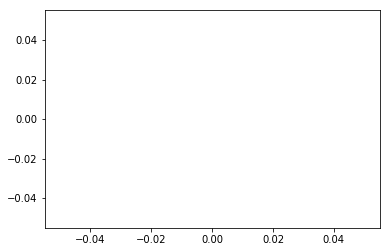

In [53]:
all_driving = np.around(all_driving * 0.621371, decimals = 3)
np.set_printoptions(suppress=True)
print (all_driving)
print (np.around (all_driving.mean(),decimals = 3))
print (np.around (np.median(all_driving), decimals = 3))
plt.plot(all_driving)

In [55]:
kmeans_rt1 = [1.776, 1.664]

In [56]:
round_rt1 = [1.756, 1.408]

In [57]:
wass_rt1 = [1.865, 1.615]

<BarContainer object of 2 artists>

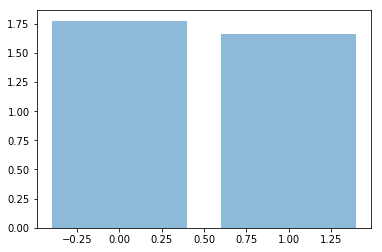

In [62]:
y_pos = np.arange(len(kmeans_rt1))
plt.bar(y_pos, kmeans_rt1, align='center', alpha=0.5)

In [ ]:
emergency = full_data.values
emergency = emergency [:,2:4]

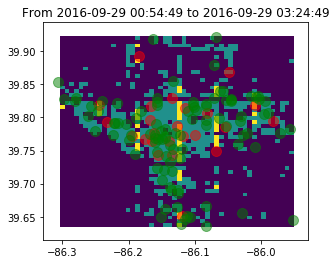

In [40]:
interval_count = 10
bincount = 50
data = grid_loc
end_time = start_time + datetime.timedelta(seconds = 15*60*interval_count)
heatmap, xedges, yedges = np.histogram2d(data[:,1], data[:,0], bins = bincount)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.title ('From {} to {}'.format(str(start_time), str(end_time)))
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.scatter(centers[:,1], centers[:,0], c = 'red', s = 100, alpha = 0.5)
plt.scatter(emergency[st:st+100,1], emergency[st:st+100,0], c = 'green', s = 100, alpha = 0.5)
plt.show()
plt.close()